In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize
from PIL import Image
import os
import librosa
import librosa.display
import IPython.display as ipd
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GaussianNoise, Reshape, Lambda, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Activation, LSTM, GRU, Bidirectional
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Normalization
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import ResNet50
from skimage.transform import resize
from sklearn.utils import shuffle
from tensorflow.keras.models import load_model

In [ ]:
import csv
with open('/kaggle/input/rfcx-species-audio-detection/train_tp.csv') as f:
    
    reader = csv.reader(f)
    data = list(reader)

In [ ]:
data[2][0]

In [ ]:
# data

In [ ]:
len(data)

In [ ]:
train_tp=pd.read_csv('/kaggle/input/rfcx-species-audio-detection/train_tp.csv')
train_fp=pd.read_csv('/kaggle/input/rfcx-species-audio-detection/train_fp.csv')
path = '/kaggle/input/rfcx-species-audio-detection/'
train_audio = os.listdir(path+'train')
test_audio = os.listdir(path+'test')


In [ ]:
train_tp.head()

In [ ]:
train_tp.f_max.describe()

In [ ]:
train_tp.f_min.describe()

In [ ]:
class params:
    """
    Parameters used for audio data
    
    """
    sr = 32000
    # Melspectrogram
    n_mels = 128
    fmin = 20
    fmax = sr // 2 
    length = 10 * sr

In [ ]:
fft = 2048
hop = 512
sr = 32000
n_mels = 128
fmin = 20
fmax = sr // 2
length = 10 * sr
print('Minimum frequency: ' + str(fmin) + ', maximum frequency: ' + str(fmax))

In [ ]:
print('Starting spectrogram generation')
for i in range(1, len(data)):
    wav, sr = librosa.load('/kaggle/input/rfcx-species-audio-detection/train/' + data[i][0] + '.flac', sr=params.sr)
    t_min = float(data[i][3]) * sr
    t_max = float(data[i][5]) * sr
    
    # Positioning sound slice
    center = np.round((t_min + t_max) / 2)
    beginning = center - length / 2
    if beginning < 0:
        beginning = 0
    ending = beginning + length
    if ending > len(wav):
        ending = len(wav)
        beginning = ending - length
    slice = wav[int(beginning):int(ending)]
    
    # Mel spectrogram generation
    mel_spec = librosa.feature.melspectrogram(slice, n_fft=fft, hop_length=hop, sr=sr, fmin=fmin, fmax=fmax, power=1.5)
    mel_spec = resize(mel_spec, (224, 400))
    # Normalize to 0...1 - this is what goes into neural net
    mel_spec = mel_spec - np.min(mel_spec)
    mel_spec = mel_spec / np.max(mel_spec)
    # And this 0...255 is for the saving in bmp format
    mel_spec = mel_spec * 255
    mel_spec = np.round(mel_spec)    
    mel_spec = mel_spec.astype('uint8')
    mel_spec = np.asarray(mel_spec)
    bmp = Image.fromarray(mel_spec, 'L')
    bmp.save('/kaggle/working/' + data[i][0] + '_' + data[i][1] + '_' + str(center) + '.bmp')
    
    if i % 100 == 0:
        print('Processed ' + str(i) + ' train examples from ' + str(len(data)))

In [ ]:
train_tp.shape,train_fp.shape

In [ ]:
print('Number of training audio files : {}'.format(len(train_audio)))
print('Number of test audio files : {}'.format(len(test_audio)))


In [ ]:
# Finding different unique species_id
train_tp.species_id.unique()

In [ ]:
# Finding number of unique species_id
train_tp.species_id.nunique()

In [ ]:
sns.countplot(train_tp['species_id'],palette = "Set2")

In [ ]:
sns.countplot(train_tp['songtype_id'])

In [ ]:
s,sr = librosa.load('/kaggle/input/rfcx-species-audio-detection/train/'+train_audio[1])
s1,sr1 = librosa.load('/kaggle/input/rfcx-species-audio-detection/train/'+train_audio[0])
print(type(s), type(sr))
print(s.shape, sr)

print(type(s1), type(sr1))
print(s1.shape, sr1)

In [ ]:
s, s.shape, sr, len(s)

In [ ]:
s1, s1.shape, sr1, len(s1)

In [ ]:
ipd.Audio(s,rate =sr)

In [ ]:
ipd.Audio(s1,rate =sr1)

In [ ]:
# Duration of one sample
sample_duration = 1/sr
print('sample_duration of train[1]: {} seconds'.format(sample_duration))
print(f"{sample_duration:6f} seconds")

In [ ]:
plt.figure(figsize=(17, 17))

plt.subplot(2, 1, 1)
librosa.display.waveplot(s, sr=sr)
plt.title('Train[1]')

plt.subplot(2, 1, 2)
librosa.display.waveplot(s1, sr=sr1)
plt.title('Train[0]')



In [ ]:
# Calculating amplitude envelope
def amplitude_envelope(signal, frame_size, hop_length):
    amplitude_envelope = []
    
    for i in range(0, len(signal), hop_length): 
        amplitude_envelope_current_frame = max(signal[i:i+frame_size]) 
        amplitude_envelope.append(amplitude_envelope_current_frame)
        
    return np.array(amplitude_envelope)

In [ ]:
# number of frames in amplitude envelope
FRAME_SIZE = 1024
HOP_LENGTH = 512
s_envlp = amplitude_envelope(s, FRAME_SIZE, HOP_LENGTH)
len(s_envlp)

In [ ]:
frames = range(len(s_envlp))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

In [ ]:
plt.figure(figsize=(17, 17))

librosa.display.waveplot(s, sr=sr)
plt.plot(t, s_envlp, color="r")
plt.title('Train[1]')
plt.show()


In [ ]:
FRAME_SIZE = 1024
HOP_LENGTH = 512

In [ ]:
rms_s = librosa.feature.rms(s, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
rms_s1 = librosa.feature.rms(s1, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

In [ ]:
rms_s.shape

In [ ]:
frames = range(len(rms_s))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

In [ ]:
# Visualise RMSE + waveform

plt.figure(figsize=(17, 17))

plt.subplot(2, 1, 1)
librosa.display.waveplot(s, sr=sr)
plt.plot(t, rms_s, color="r")
plt.title('Train[1]')

plt.subplot(2, 1, 2)
librosa.display.waveplot(s1, sr=sr1)
plt.plot(t, rms_s1, color="r")
plt.title('Train[0]')

plt.show()

In [ ]:
# Zero-crossing rate with Librosa

zcr_s = librosa.feature.zero_crossing_rate(s, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
zcr_s1 = librosa.feature.zero_crossing_rate(s1, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

In [ ]:
zcr_s.shape

In [ ]:
plt.figure(figsize=(17, 17))

plt.subplot(2, 1, 1)
librosa.display.waveplot(s, sr=sr)
plt.plot(t, zcr_s, color="g")
plt.title('Train[1]')

plt.subplot(2, 1, 2)
librosa.display.waveplot(s1, sr=sr1)
plt.plot(t, zcr_s1, color="g")
plt.title('Train[0]')

plt.show()

In [ ]:
plt.figure(figsize=(15, 10))

plt.plot(t, zcr_s, color="y")
plt.plot(t, zcr_s1, color="m")

plt.ylim(0, 1)
plt.show()


In [ ]:
plt.figure(figsize=(15, 10))

plt.plot(t, zcr_s * FRAME_SIZE, color="y")
plt.plot(t, zcr_s1* FRAME_SIZE, color="m")

plt.show()

In [ ]:
train_audio[1]

In [ ]:
train_tp.loc[train_tp.recording_id =='e6af91bbf' ]

In [ ]:
X = librosa.stft(s)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

In [ ]:
# Creating melspectrogram
S = librosa.feature.melspectrogram(y=s, sr=sr)
S,S.shape

In [ ]:
# Creating melspectrogram
S2 = librosa.feature.melspectrogram(s1, sr1)
S2,S2.shape

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(librosa.power_to_db(S,ref=np.max), sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [ ]:
train_tp

In [ ]:
# Creating a column containg total number of species_id in a recording_id
total_species_per_recording = train_tp.groupby('recording_id')['species_id'].count()
total_species_per_recording = pd.DataFrame(total_species_per_recording)
total_species_per_recording = total_species_per_recording.rename(columns = {'species_id':'total_species_per_recording'})
total_species_per_recording
train_tp = train_tp.merge(total_species_per_recording, how='left', on='recording_id')


In [ ]:
train_tp

In [ ]:
sns.countplot(train_tp['total_species_per_recording'])

In [ ]:
train_tp.loc[train_tp.recording_id == '5f8eecc9e']


In [ ]:
train_tp.loc[train_tp.songtype_id==4]

In [ ]:
# Number of unique songtype_id for each species_id
train_tp.groupby(by='species_id', as_index=False).agg({'songtype_id': pd.Series.nunique})

In [ ]:
train_tp

In [ ]:
train_tp['total_time'] = train_tp['t_max']-train_tp['t_min']
train_tp.head()

In [ ]:
sns.set_style('whitegrid') 
sns.distplot(train_tp['total_time'], kde = False, color ='red', bins = 30) 

In [ ]:
sns.barplot(x ='species_id', y ='total_time', data = train_tp)

In [ ]:
train_tp

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_tp['recording_id'],train_tp['species_id'],test_size=0.20, random_state=101)

In [ ]:
train_tp['recording_id']

In [ ]:
X_train

In [ ]:
train_tp['species_id']

In [ ]:
y_train

In [ ]:
train_df = pd.concat([X_train,y_train],axis=1)
test_df = pd.concat([X_test,y_test],axis=1)
train_df

In [ ]:
# Onehot encode labels
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
enc = LabelBinarizer()
train_onehot = enc.fit_transform((np.array(y_train)).reshape(len(X_train),1))
test_onehot  = enc.fit_transform((np.array(y_test)).reshape(len(X_test),1))

# add to dataframes
train_df['onehot_label'] = train_onehot.tolist()
test_df['onehot_label'] = test_onehot.tolist()

train_df.head()

In [ ]:
print('Starting spectrogram generation')
for i in range(1, len(data)):
    wav, sr = librosa.load('/kaggle/input/rfcx-species-audio-detection/train/' + data[i][0] + '.flac', sr=params.sr)
    t_min = float(data[i][3]) * sr
    t_max = float(data[i][5]) * sr
    
    # Positioning sound slice
    center = np.round((t_min + t_max) / 2)
    beginning = center - length / 2
    if beginning < 0:
        beginning = 0
    ending = beginning + length
    if ending > len(wav):
        ending = len(wav)
        beginning = ending - length
    slice = wav[int(beginning):int(ending)]
    
    # Mel spectrogram generation
    mel_spec = librosa.feature.melspectrogram(slice, n_fft=fft, hop_length=hop, sr=sr, fmin=fmin, fmax=fmax, power=1.5)
    mel_spec = resize(mel_spec, (224, 400))
    # Normalize to 0...1 - this is what goes into neural net
    mel_spec = mel_spec - np.min(mel_spec)
    mel_spec = mel_spec / np.max(mel_spec)
    # And this 0...255 is for the saving in bmp format
    mel_spec = mel_spec * 255
    mel_spec = np.round(mel_spec)    
    mel_spec = mel_spec.astype('uint8')
    mel_spec = np.asarray(mel_spec)
    bmp = Image.fromarray(mel_spec, 'L')
    bmp.save('/kaggle/working/' + data[i][0] + '_' + data[i][1] + '_' + str(center) + '.bmp')
    
    if i % 100 == 0:
        print('Processed ' + str(i) + ' train examples from ' + str(len(data)))

In [ ]:
# Create spectrogram function
def create_spec(audio_path,shape,third_dim=False):
    shape = np.array(shape)
    # load audio and get sample rate
    wav, sample_rate = librosa.load(audio_path, sr=sr)
    t_min = float(data[i][3]) * sr
    t_max = float(data[i][5]) * sr
     # Positioning sound slice
    center = np.round((t_min + t_max) / 2)
    beginning = center - length / 2
    if beginning < 0:
        beginning = 0
    ending = beginning + length
    if ending > len(wav):
        ending = len(wav)
        beginning = ending - length
    slice = wav[int(beginning):int(ending)]
    
    
    
    # Mel spectrogram generation
    mel_spec = librosa.feature.melspectrogram(slice, n_fft=fft, hop_length=hop, sr=sr, fmin=fmin, fmax=fmax, power=1.5)
#     stft = librosa.feature.melspectrogram(wav, sr=sample_rate)
#     stft_to_db = librosa.power_to_db(stft,ref=np.max)
    # resize array
#     stft_to_db = resize(stft_to_db, shape)
    mel_spec = resize(mel_spec,  shape)
    # normalize 
#     stft_to_db = stft_to_db - np.min(stft_to_db)
#     stft_to_db = stft_to_db / np.max(stft_to_db)
    mel_spec = mel_spec - np.min(mel_spec)
    mel_spec = mel_spec / np.max(mel_spec)
    if third_dim == True:
        
        mel_spec = np.stack((mel_spec,mel_spec,mel_spec))
    return(stft_to_db)


    

In [ ]:
data = {'index':[],'recording_id':[],'spec_data':[],'label':[]}
# set paths
root_path = '../input/rfcx-species-audio-detection/train/'
file_ext = '.flac'
shape=(224, 400)
power = 1.5
n=0
# loop through each row in dataframe
for index, row in train_df.iterrows():
    # create filepath
    f_path = root_path+row['recording_id']+file_ext
    data['index'].append(index)
    data['recording_id'].append(row['recording_id'])
    temp_spec = create_spec(f_path,shape,third_dim=True)
    temp_spec = temp_spec.reshape(temp_spec.shape[1], temp_spec.shape[2], temp_spec.shape[0])
    data['spec_data'].append(temp_spec)
    data['label'].append(np.array(row['onehot_label']))
    n+=1
    if n%100 == 0:
        print(n,'files processed')

In [ ]:
train_df

In [ ]:
pd.DataFrame.from_dict(data)

In [ ]:
val_data  = {'index':[],
        'recording_id':[],'spec_data':[],'label':[]}
root_path = '../input/rfcx-species-audio-detection/train/'
file_ext = '.flac'
# set counter
n=0
shape=(256,512)

# loop through each row in dataframe
for index, row in test_df.iterrows():
    # create filepath
    f_path = root_path+row['recording_id']+file_ext
    val_data['index'].append(index)
    val_data['recording_id'].append(row['recording_id'])
    temp_spec = create_spec(f_path,shape,third_dim=True)
    temp_spec = temp_spec.reshape(temp_spec.shape[1], temp_spec.shape[2], temp_spec.shape[0])
    val_data['spec_data'].append(temp_spec)
    #data['label'].append(row['onehot_label'])
    val_data['label'].append(np.array(row['onehot_label']))
    
    n+=1
    if n%100 == 0:
        print(n,'files processed')

In [ ]:
pd.DataFrame.from_dict(val_data)

In [ ]:
# name = root_path+'8e0f816f1'+file_ext
# spec = create_spec(name,shape=(256,512))
# # display spectrogram
# librosa.display.specshow(spec, x_axis='time', y_axis='mel')
# spec.shape


In [ ]:
@tf.function
def _one_sample_positive_class_precisions(example):
    y_true, y_pred = example

    retrieved_classes = tf.argsort(y_pred, direction='DESCENDING')
    class_rankings = tf.argsort(retrieved_classes)
    retrieved_class_true = tf.gather(y_true, retrieved_classes)
    retrieved_cumulative_hits = tf.math.cumsum(tf.cast(retrieved_class_true, tf.float32))

    idx = tf.where(y_true)[:, 0]
    i = tf.boolean_mask(class_rankings, y_true)
    r = tf.gather(retrieved_cumulative_hits, i)
    c = 1 + tf.cast(i, tf.float32)
    precisions = r / c

    dense = tf.scatter_nd(idx[:, None], precisions, [y_pred.shape[0]])
    return dense


class LWLRAP(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='lwlrap'):
        super().__init__(name=name)

        self._precisions = self.add_weight(
            name='per_class_cumulative_precision',
            shape=[num_classes],
            initializer='zeros',
        )

        self._counts = self.add_weight(
            name='per_class_cumulative_count',
            shape=[num_classes],
            initializer='zeros',
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        precisions = tf.map_fn(
            fn=_one_sample_positive_class_precisions,
            elems=(y_true, y_pred),
            dtype=(tf.float32),
        )

        increments = tf.cast(precisions > 0, tf.float32)
        total_increments = tf.reduce_sum(increments, axis=0)
        total_precisions = tf.reduce_sum(precisions, axis=0)

        self._precisions.assign_add(total_precisions)
        self._counts.assign_add(total_increments)        

    def result(self):
        per_class_lwlrap = self._precisions / tf.maximum(self._counts, 1.0)
        per_class_weight = self._counts / tf.reduce_sum(self._counts)
        overall_lwlrap = tf.reduce_sum(per_class_lwlrap * per_class_weight)
        return overall_lwlrap

    def reset_states(self):
        self._precisions.assign(self._precisions * 0)
        self._counts.assign(self._counts * 0)

In [ ]:
image_input = keras.layers.Input(shape=(shape[0],shape[1], 3))

restnet = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)
#restnet = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=image_input)

output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, restnet.output)

for layer in restnet.layers:
    layer.trainable = False


# Add final layers for rainforest classifier
# instantiate model
model = keras.models.Sequential()

# add resnet model
model.add(restnet)
#model.add(layers.Flatten())
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1024, activation='relu'))
#     model.add(keras.layers.BatchNormalization())
#     model.add(keras.layers.Dropout(0.4))
#     model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(24, activation='softmax'))

# set optimizer
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
#optimizer = tfa.optimizers.RectifiedAdam(lr=0.002, total_steps=1152, warmup_proportion=0.3, min_lr=.000001)

model.compile(optimizer=optimizer,
              #loss=tfa.losses.SigmoidFocalCrossEntropy(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[LWLRAP(24)])
              #metrics=['accuracy'])
model.summary()
  

In [ ]:
filepath = "saved-model-best.hdf5"
my_callbacks = [keras.callbacks.ModelCheckpoint(filepath, monitor='val_lwlrap', verbose=0,
                                                save_best_only=True, mode='max')]

In [ ]:
history = model.fit(np.array(data['spec_data']), np.array(data['label']), epochs=100, batch_size=96,
                    validation_data=(np.array(val_data['spec_data']), np.array(val_data['label'])),
                    shuffle=True, callbacks=[my_callbacks])

In [ ]:
# plot model history
plt.figsize=(15,7)
plt.plot(history.history['lwlrap'], color='g', label='lwlrap')
plt.plot(history.history['val_lwlrap'], color='m', label='val_lwlrap')
plt.legend(loc='best', shadow=True)
plt.show()

In [ ]:
def create_test_spec(audio, shape, sr=sr, third_dim=True):
    
    # initialize list 
    final_list = []
    # break audio into 10 seconds sub arrays
    audio = np.split(audio, 10)
    # loop through sub arrays
    for sub_array in audio:
        stft = librosa.feature.melspectrogram(sub_array, sr=sr, n_mels=shape[0])
        stft_to_db = librosa.power_to_db(stft,ref=np.max)
        # resize array
        stft_to_db = resize(stft_to_db, shape)
        # normalize 
        stft_to_db = stft_to_db - np.min(stft_to_db)
        stft_to_db = stft_to_db / np.max(stft_to_db)
        if third_dim == True:
            stft_to_db = np.stack((stft_to_db,stft_to_db,stft_to_db))
        # reshape output
        stft_to_db = stft_to_db.reshape(stft_to_db.shape[1], stft_to_db.shape[2], stft_to_db.shape[0])
        # append stft_to_db to list
        final_list.append(stft_to_db)
    return(final_list)


In [ ]:
# load model
model = keras.models.load_model('./saved-model-best.hdf5', compile=False)

In [ ]:
# compile model
model.compile(optimizer=optimizer,
              
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[LWLRAP(24)])
              

In [ ]:
# get test headers from sample_submission.csv
temp = pd.read_csv('../input/rfcx-species-audio-detection/sample_submission.csv')
cols = temp.columns.tolist()
n=0

# initialize list
prediction_list = []

# loop through test files
test_path = '../input/rfcx-species-audio-detection/test'
for root, dirs, files in os.walk(test_path):
    total = len(files)
    
    # loop through files 
    for file in files:
        # load in audio
        loaded_audio, sample_rate = librosa.load(test_path+'/'+file, sr=None)
        
        # pass loaded_audio to create_test_spec function
        test_list = create_test_spec(loaded_audio, shape=shape)
        
        # get predictions
        preds = model.predict(np.array(test_list))
        
        # get mean prediction probabilities
        mean_preds = np.mean(preds, axis=0)
        
        # append mean probs to list
        prediction_list.append(mean_preds)
        
        if n%100 == 0:
            print(f'{n} of {total} files processed')
        n+=1
        
# convert final list to dataframe --> this is messy and needs to be cleaned up
sub_df = pd.DataFrame({cols[0]:files})
cols2 = cols[1:]
temp_df= pd.DataFrame(prediction_list, columns=cols2)
temp_df['recording_id']=files
sub_df = temp_df[cols]

# eliminate file extension
sub_df['recording_id'] = sub_df['recording_id'].str.replace(r'.flac$','')

In [ ]:
sub_df.head()

In [ ]:
# create submission .csv
sub_df.to_csv('./submission.csv',index=False)

In [ ]:
data[1]

In [ ]:
from pathlib import Path
from tqdm.notebook import tqdm

In [ ]:
DATA_ROOT = Path("../input/rfcx-species-audio-detection")
TRAIN_AUDIO_ROOT = Path("../input/rfcx-species-audio-detection/train")
TEST_AUDIO_ROOT = Path("../input/rfcx-species-audio-detection/test")

In [ ]:
train_df = pd.DataFrame({
    "recording_id": [path.stem for path in Path(TRAIN_AUDIO_ROOT).glob("*.flac")],
})

test_df = pd.DataFrame({
    "recording_id": [path.stem for path in Path(TEST_AUDIO_ROOT).glob("*.flac")],
})

In [ ]:
train_df.head()

In [ ]:
class params:
    """
    Parameters used for audio data
    
    """
    sr = 32000
    # Melspectrogram
    n_mels = 128
    fmin = 20
    fmax = sr // 2 

In [ ]:
def load_audio(record, sr=16000, root=""):
    y, _ = librosa.load(
        root.joinpath(record).with_suffix(".flac").as_posix(),
        sr=sr, 
    )
    return y


In [ ]:
def compute_melspec(y, params):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    melspec = librosa.feature.melspectrogram(y, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax)
    melspec = librosa.power_to_db(melspec).astype(np.float32)
    return melspec


In [ ]:
ex = load_audio(train_df["recording_id"][0], params.sr, TRAIN_AUDIO_ROOT)

In [ ]:
ex

In [ ]:
melspec = compute_melspec(ex, params)
melspec

In [ ]:
plt.figure(figsize=(15, 7))
librosa.display.specshow(melspec[:, :512], sr=params.sr,x_axis='time',y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()


In [ ]:
np.save("melspec.npy", melspec)

In [ ]:
%%timeit 

spec = np.load("melspec.npy")

In [ ]:
%%timeit 

y = load_audio(train_df["recording_id"][0], params.sr, TRAIN_AUDIO_ROOT)
melspec = compute_melspec(y, params)

In [ ]:
import torch.utils.data as torchdata
class RainforestDataset(torchdata.Dataset):
    def __init__(self,filelist):
        
        self.specs = []
        self.labels = []
        for f in filelist:
            
            
            
        
            label = int(str.split(f, '_')[1])
            label_array = np.zeros(num_birds, dtype=np.single)
            label_array[label] = 1.
            self.labels.append(label_array)
        
            img = Image.open('/kaggle/working/' + f)
            mel_spec = np.array(img)
            img.close()
        
             # Transforming spectrogram from bmp to 0..1 array
            mel_spec = mel_spec / 255
             # Stacking for 3-channel image for resnet
            mel_spec = np.stack((mel_spec, mel_spec, mel_spec))
            
            self.specs.append(mel_spec)
    
    def __len__(self):
        return len(self.specs)
    
    def __getitem__(self, item):
        return self.specs[item], self.labels[item]
    
    

In [ ]:
file_list = []
label_list = []
for f in os.listdir('/kaggle/working/'):
    
    if '.bmp' in f:
        file_list.append(f)
        label = str.split(f, '_')[1]
        label_list.append(label)
        
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True)

train_files = []
val_files = []

for fold_id, (train_index, val_index) in enumerate(skf.split(file_list, label_list)):
    if fold_id == 0:
        train_files = np.take(file_list, train_index)
        val_files = np.take(file_list, val_index)

print('Training on ' + str(len(train_files)) + ' examples')
print('Validating on ' + str(len(val_files)) + ' examples')
        

In [ ]:
!pip install resnest > /dev/null

In [ ]:
import torch
import random
import torch.nn as nn
from resnest.torch import resnest50


num_birds = 24
# 6GB GPU-friendly (~4 GB used by model)
# Increase if neccesary
batch_size = 16


train_dataset = RainforestDataset(train_files)
val_dataset = RainforestDataset(val_files)

train_loader = torchdata.DataLoader(train_dataset, batch_size=batch_size, sampler=torchdata.RandomSampler(train_dataset))
val_loader = torchdata.DataLoader(val_dataset, batch_size=batch_size, sampler=torchdata.RandomSampler(val_dataset))

# ResNeSt: Split-Attention Networks
# https://arxiv.org/abs/2004.08955
# Significantly outperforms standard Resnet
model = resnest50(pretrained=True)

model.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(1024, num_birds)
)

# Picked for this notebook; pick new ones after major changes (such as adding train_fp to train data)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.4)

# This loss function is not exactly suited for competition metric, which only cares about ranking of predictions
# Exploring different loss fuctions would be a good idea
pos_weights = torch.ones(num_birds)
pos_weights = pos_weights * num_birds
loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weights)



In [ ]:
best_corrects = 0

# Train loop
print('Starting training loop')
for e in range(0, 32):
    # Stats
    train_loss = []
    train_corr = []
    # Single epoch - train
    model.train()
    for batch, (data, target) in enumerate(train_loader):
        data = data.float()
        optimizer.zero_grad()
        
        output = model(data)
        loss = loss_function(output, target)
        
        loss.backward()
        optimizer.step()
        
        # Stats
        vals, answers = torch.max(output, 1)
        vals, targets = torch.max(target, 1)
        corrects = 0
        
        for i in range(0, len(answers)):
                
                if answers[i] == targets[i]:
                    
                    corrects = corrects + 1
        train_corr.append(corrects)
        train_loss.append(loss.item())
       # Stats
    for g in optimizer.param_groups:
        
        lr = g['lr']
    print('Epoch ' + str(e) + str(lr) + ', Loss: ' + str(sum(train_loss) / len(train_loss)) +
          ', Correct answers: ' + str(sum(train_corr)) + '/' + str(train_dataset.__len__()))
    
    with torch.no_grad():
        # Stats
        val_loss = []
        val_corr = []
        
        model.eval()
        for batch, (data, target) in enumerate(val_loader):
            data = data.float()
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            loss = loss_function(output, target)
            
            # Stats
            vals, answers = torch.max(output, 1)
            vals, targets = torch.max(target, 1)
            corrects = 0
            for i in range(0, len(answers)):
                if answers[i] == targets[i]:
                    corrects = corrects + 1
            val_corr.append(corrects)
        
            val_loss.append(loss.item())
    
    # Stats
    print('Epoch ' + str(e) + + str(lr) + ', Loss: ' + str(sum(val_loss) / len(val_loss)) +
          ', Correct answers: ' + str(sum(val_corr)) + '/' + str(val_dataset.__len__()))
    if sum(val_corr) > best_corrects:
        print('Saving new best model at epoch ' + str(e) + ' (' + str(sum(val_corr)) + '/' + str(val_dataset.__len__()) + ')')
        torch.save(model, 'best_model.pt')
        best_corrects = sum(val_corr)
        
    # Call every epoch
    scheduler.step()
# Free memory
del model

In [2]:
import tensorflow_addons as tfa

In [4]:
!pip install image-classifiers

     |████████████████████████████████| 50 kB 1.4 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
from classification_models.keras import Classifiers
ResNet34, preprocess_input = Classifiers.get('resnet34')

In [6]:
cfg = {
    'parse_params': {
        'cut_time': 10,
    },
    'data_params': {
        'sample_time': 6, # assert 60 % sample_time == 0
        'spec_fmax': 24000.0,
        'spec_fmin': 40.0,
        'spec_mel': 384, 
        'mel_power': 2,
        'img_shape': (384, 768)
    },
    'model_params': {
        'batchsize_per_tpu': 18,
        'iteration_per_epoch': 64,
        'epoch': 18, 
        'arch': ResNet34,
        'arch_preprocess': preprocess_input,
        'freeze_to': 0,  # Freeze to backbone.layers[:freeze_to]. If None, all layers in the backbone will be freezed.
        'loss': {
            'fn': tfa.losses.SigmoidFocalCrossEntropy,
            'params': {},
        },
        'optim': {
            'fn': tfa.optimizers.RectifiedAdam,
            'params': {'lr': 2e-3, 'total_steps': 18*64, 'warmup_proportion': 0.3, 'min_lr': 1e-6},
        },
        'mixup': True # False
    }
}

In [8]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU')]


In [9]:
strategy = tf.distribute.experimental.TPUStrategy(tpu)
from kaggle_datasets import KaggleDatasets
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_DS_PATH = KaggleDatasets().get_gcs_path('rfcx-species-audio-detection')

TRAIN_TFREC = GCS_DS_PATH + "/tfrecords/train"
TEST_TFREC = GCS_DS_PATH + "/tfrecords/test"


In [10]:
CUT = cfg['parse_params']['cut_time']
SR = 48000     # all wave's sample rate may be 48k

TIME = cfg['data_params']['sample_time']

FMAX = cfg['data_params']['spec_fmax']
FMIN = cfg['data_params']['spec_fmin']
N_MEL = cfg['data_params']['spec_mel']

HEIGHT, WIDTH = cfg['data_params']['img_shape']

CLASS_N = 24


In [11]:
raw_dataset = tf.data.TFRecordDataset([TRAIN_TFREC + '/00-148.tfrec'])
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [12]:
feature_description = {
    'recording_id': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'audio_wav': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'label_info': tf.io.FixedLenFeature([], tf.string, default_value=''),
}

parse_dtype = {
    'audio_wav': tf.float32,
    'recording_id': tf.string,
    'species_id': tf.int32,
    'songtype_id': tf.int32,
    't_min': tf.float32,
    'f_min': tf.float32,
    't_max': tf.float32,
    'f_max':tf.float32,
    'is_tp': tf.int32
}

@tf.function
def _parse_function(example_proto):
    sample = tf.io.parse_single_example(example_proto, feature_description)
    wav, _ = tf.audio.decode_wav(sample['audio_wav'], desired_channels=1) # mono
    label_info = tf.strings.split(sample['label_info'], sep='"')[1]
    labels = tf.strings.split(label_info, sep=';')
    
    @tf.function
    def _cut_audio(label):
        items = tf.strings.split(label, sep=',')
        spid = tf.squeeze(tf.strings.to_number(items[0], tf.int32))
        soid = tf.squeeze(tf.strings.to_number(items[1], tf.int32))
        tmin = tf.squeeze(tf.strings.to_number(items[2]))
        fmin = tf.squeeze(tf.strings.to_number(items[3]))
        tmax = tf.squeeze(tf.strings.to_number(items[4]))
        fmax = tf.squeeze(tf.strings.to_number(items[5]))
        tp = tf.squeeze(tf.strings.to_number(items[6], tf.int32))

        tmax_s = tmax * tf.cast(SR, tf.float32)
        tmin_s = tmin * tf.cast(SR, tf.float32)
        cut_s = tf.cast(CUT * SR, tf.float32)
        all_s = tf.cast(60 * SR, tf.float32)
        tsize_s = tmax_s - tmin_s
        cut_min = tf.cast(
            tf.maximum(0.0, 
                tf.minimum(tmin_s - (cut_s - tsize_s) / 2,
                           tf.minimum(tmax_s + (cut_s - tsize_s) / 2, all_s) - cut_s)
            ), tf.int32
        )
        cut_max = cut_min + CUT * SR
        
        _sample = {
            'audio_wav': tf.reshape(wav[cut_min:cut_max], [CUT*SR]),
            'recording_id': sample['recording_id'],
            'species_id': spid,
            'songtype_id': soid,
            't_min': tmin - tf.cast(cut_min, tf.float32)/tf.cast(SR, tf.float32),
            'f_min': fmin,
            't_max': tmax - tf.cast(cut_min, tf.float32)/tf.cast(SR, tf.float32),
            'f_max': fmax,
            'is_tp': tp
        }
        return _sample
    
    samples = tf.map_fn(_cut_audio, labels, dtype=parse_dtype)
    return samples

parsed_dataset = raw_dataset.map(_parse_function).unbatch()

In [13]:
@tf.function
def _cut_wav(x):
    # random cut in training
    cut_min = tf.random.uniform([], maxval=(CUT-TIME)*SR, dtype=tf.int32)
    cut_max = cut_min + TIME * SR
    cutwave = tf.reshape(x['audio_wav'][cut_min:cut_max], [TIME*SR])
    y = {}
    y.update(x)
    y['audio_wav'] = cutwave
    y['t_min'] = tf.maximum(0.0, x['t_min'] - tf.cast(cut_min, tf.float32) / SR)
    y['t_max'] = tf.maximum(0.0, x['t_max'] - tf.cast(cut_min, tf.float32) / SR)
    return y
    
@tf.function
def _cut_wav_val(x):
    # center crop in validation
    cut_min = (CUT-TIME)*SR // 2
    cut_max = cut_min + TIME * SR
    cutwave = tf.reshape(x['audio_wav'][cut_min:cut_max], [TIME*SR])
    y = {}
    y.update(x)
    y['audio_wav'] = cutwave
    y['t_min'] = tf.maximum(0.0, x['t_min'] - tf.cast(cut_min, tf.float32) / SR)
    y['t_max'] = tf.maximum(0.0, x['t_max'] - tf.cast(cut_min, tf.float32) / SR)
    return y

In [14]:
@tf.function
def _filtTP(x):
    return x['is_tp'] == 1

In [15]:
from IPython.display import Audio

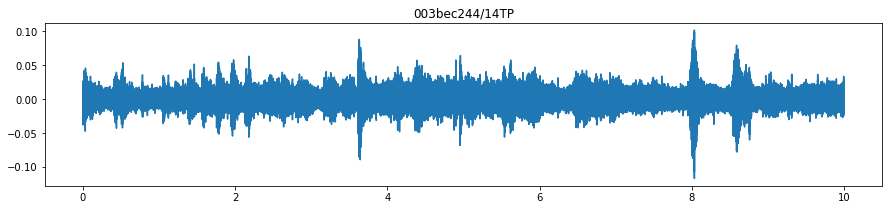

In [16]:
def show_wav(sample, ax):
    wav = sample["audio_wav"].numpy()
    rate = SR
    ax.plot(np.arange(len(wav)) / rate, wav)
    ax.set_title(
        sample["recording_id"].numpy().decode()
        + ("/%d" % sample["species_id"])
        + ("TP" if sample["is_tp"] else "FP"))

    return Audio((wav * 2**15).astype(np.int16), rate=rate)

fig, ax = plt.subplots(figsize=(15, 3))
show_wav(next(iter(parsed_dataset)), ax)

In [17]:
@tf.function
def _wav_to_spec(x):
    mel_power = cfg['data_params']['mel_power']
    
    stfts = tf.signal.stft(x["audio_wav"], frame_length=2048, frame_step=512, fft_length=2048)
    spectrograms = tf.abs(stfts) ** mel_power

    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = FMIN, FMAX, N_MEL
    
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, SR, lower_edge_hertz,
      upper_edge_hertz)
    mel_spectrograms = tf.tensordot(
      spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    y = {
        'audio_spec': tf.transpose(log_mel_spectrograms), # (num_mel_bins, frames)
    }
    y.update(x)
    return y

spec_dataset = parsed_dataset.filter(_filtTP).map(_cut_wav).map(_wav_to_spec)

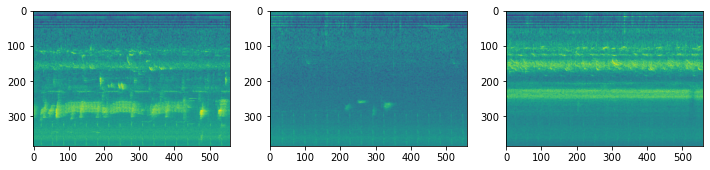

In [18]:
plt.figure(figsize=(12,5))
for i, s in enumerate(spec_dataset.take(3)):
    plt.subplot(1,3,i+1)
    plt.imshow(s['audio_spec'])
plt.show()

In [19]:
import librosa.display
import matplotlib.patches as patches

def show_spectrogram(sample, ax, showlabel=False):
    S_dB = sample["audio_spec"].numpy()
    img = librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='mel', sr=SR,
                             fmax=FMAX, fmin=FMIN, ax=ax, cmap='magma')
    ax.set(title=f'Mel-frequency spectrogram of {sample["recording_id"].numpy().decode()}')
    sid, fmin, fmax, tmin, tmax, istp = (
            sample["species_id"], sample["f_min"], sample["f_max"], sample["t_min"], sample["t_max"], sample["is_tp"])
    ec = '#00ff00' if istp == 1 else '#0000ff'
    ax.add_patch(
        patches.Rectangle(xy=(tmin, fmin), width=tmax-tmin, height=fmax-fmin, ec=ec, fill=False)
    )

    if showlabel:
        ax.text(tmin, fmax, 
        f"{sid.numpy().item()} {'tp' if istp == 1 else 'fp'}",
        horizontalalignment='left', verticalalignment='bottom', color=ec, fontsize=16)

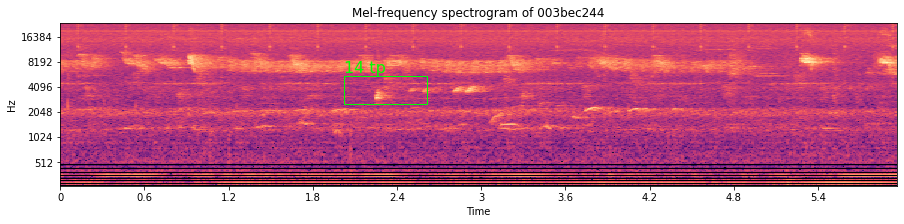

In [20]:
fig, ax = plt.subplots(figsize=(15,3))
show_spectrogram(next(iter(spec_dataset)), ax, showlabel=True)


In [21]:
@tf.function
def _create_annot(x):
    targ = tf.one_hot(x["species_id"], CLASS_N, on_value=x["is_tp"], off_value=0)
    
    return {
        'input': x["audio_spec"],
        'target': tf.cast(targ, tf.float32)
    }

annot_dataset = spec_dataset.map(_create_annot)

In [22]:
@tf.function
def _preprocess_img(x, training=False, test=False):
    image = tf.expand_dims(x, axis=-1)
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = tf.image.per_image_standardization(image)
    
    @tf.function
    def _specaugment(image):
        ERASE_TIME = 50
        ERASE_MEL = 16
        image = tf.expand_dims(image, axis=0)
        xoff = tf.random.uniform([2], minval=ERASE_TIME//2, maxval=WIDTH-ERASE_TIME//2, dtype=tf.int32)
        xsize = tf.random.uniform([2], minval=ERASE_TIME//2, maxval=ERASE_TIME, dtype=tf.int32)
        yoff = tf.random.uniform([2], minval=ERASE_MEL//2, maxval=HEIGHT-ERASE_MEL//2, dtype=tf.int32)
        ysize = tf.random.uniform([2], minval=ERASE_MEL//2, maxval=ERASE_MEL, dtype=tf.int32)
        image = tfa.image.cutout(image, [HEIGHT, xsize[0]], offset=[HEIGHT//2, xoff[0]])
        image = tfa.image.cutout(image, [HEIGHT, xsize[1]], offset=[HEIGHT//2, xoff[1]])
        image = tfa.image.cutout(image, [ysize[0], WIDTH], offset=[yoff[0], WIDTH//2])
        image = tfa.image.cutout(image, [ysize[1], WIDTH], offset=[yoff[1], WIDTH//2])
        image = tf.squeeze(image, axis=0)
        return image
    
    if training:
        # gaussian
        gau = tf.keras.layers.GaussianNoise(0.3)
        image = tf.cond(tf.random.uniform([]) < 0.5, lambda: gau(image, training=True), lambda: image)
        # brightness
        image = tf.image.random_brightness(image, 0.2)
        # random left right flip (NEW)
        image = tf.image.random_flip_left_right(image)
        # specaugment
        image = tf.cond(tf.random.uniform([]) < 0.5, lambda: _specaugment(image), lambda: image)
        
    if test:
        # Insert augmentations for TTA here
        #image = tf.cond(tf.random.uniform([]) < 0.5, lambda: _specaugment(image), lambda: image)
        pass
        
    image = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image)) * 255.0 # rescale to [0, 255]
    image = tf.image.grayscale_to_rgb(image)
    image = cfg['model_params']['arch_preprocess'](image)

    return image

@tf.function
def _preprocess(x):
    image = _preprocess_img(x['input'], training=True, test=False)
    return (image, x["target"])

@tf.function
def _preprocess_val(x):
    image = _preprocess_img(x['input'], training=False, test=False)
    return (image, x["target"])

@tf.function
def _preprocess_test(x):
    image = _preprocess_img(x['audio_spec'], training=False, test=True)
    return (image, x["recording_id"])

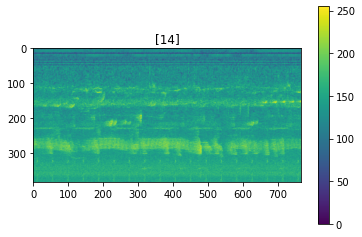

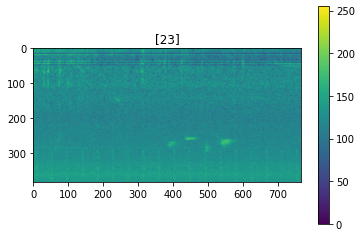

In [23]:
for inp, targ in annot_dataset.map(_preprocess).take(2):
    plt.imshow(inp.numpy()[:,:,0])
    t = targ.numpy()
    if t.sum() == 0:
        plt.title(f'FP')
    else:
        plt.title(f'{t.nonzero()[0]}')
    plt.colorbar()
    plt.show()

In [24]:
def create_model():
    with strategy.scope():
        #backbone = cfg['model_params']['arch'](include_top=False, weights='imagenet')
        backbone = cfg['model_params']['arch']((224, 224, 3), include_top=False, weights='imagenet')
        
        if cfg['model_params']['freeze_to'] is None:
            for layer in backbone.layers:
                layer.trainable = False
        else:
            for layer in backbone.layers[:cfg['model_params']['freeze_to']]:
                layer.trainable = False

        model = tf.keras.Sequential([
            backbone,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=tf.keras.initializers.he_normal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(CLASS_N, bias_initializer=tf.keras.initializers.Constant(-2.))])
    return model

model = create_model()
model.summary()

85524480/85521592 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         21302473  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________

In [25]:
# def create_model():
#     backbone = cfg['model_params']['arch']((224, 224, 3), include_top=False, weights='imagenet')
#     if cfg['model_params']['freeze_to'] is None:
        
        
        
#         for layer in backbone.layers:
            
#             layer.trainable = False
#     else:
        
        
#         for layer in backbone.layers[:cfg['model_params']['freeze_to']]:
            
#             layer.trainable = False
#     model = tf.keras.Sequential([backbone,
#             tf.keras.layers.GlobalAveragePooling2D(),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.Dropout(0.4),
#             tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=tf.keras.initializers.he_normal()),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.Dropout(0.4),
#             tf.keras.layers.Dense(CLASS_N, bias_initializer=tf.keras.initializers.Constant(-2.))])
#     return model

# model = create_model()
# model.summary()            
    
    

In [26]:
@tf.function
def _mixup(inp, targ):
    indice = tf.range(len(inp))
    indice = tf.random.shuffle(indice)
    sinp = tf.gather(inp, indice, axis=0)
    starg = tf.gather(targ, indice, axis=0)
    
    alpha = 0.2
    t = tf.compat.v1.distributions.Beta(alpha, alpha).sample([len(inp)])
    tx = tf.reshape(t, [-1, 1, 1, 1])
    ty = tf.reshape(t, [-1, 1])
    x = inp * tx + sinp * (1-tx)
    y = targ * ty + starg * (1-ty)
#     y = tf.minimum(targ + starg, 1.0) # for multi-label???
    return x, y

In [27]:
tfrecs = sorted(tf.io.gfile.glob(TRAIN_TFREC + '/*.tfrec'))
parsed_trainval = (tf.data.TFRecordDataset(tfrecs, num_parallel_reads=AUTOTUNE)
                    .map(_parse_function, num_parallel_calls=AUTOTUNE).unbatch()
                    .filter(_filtTP).enumerate())

In [28]:
from tqdm import tqdm

In [29]:
indices = []
spid = []
recid = []

for i, sample in tqdm(parsed_trainval.prefetch(AUTOTUNE)):
    indices.append(i.numpy())
    spid.append(sample['species_id'].numpy())
    recid.append(sample['recording_id'].numpy().decode())

1216it [00:45, 26.74it/s]


In [30]:
table = pd.DataFrame({'indices': indices, 'species_id': spid, 'recording_id': recid})
table

,indices,species_id,recording_id
0,0,14,003bec244
1,1,12,2026bced7
2,2,21,422de4e4d
3,3,6,60a493ad4
4,4,13,8080b2283
...,...,...,...
1211,1211,3,807efd6bb
1212,1212,20,a6610076b
1213,1213,23,c91cae4aa
1214,1214,3,c91cae4aa


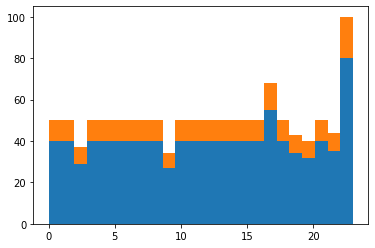

In [31]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
splits = list(skf.split(table.index, table.species_id))

plt.hist([table.loc[splits[0][0], 'species_id'], table.loc[splits[0][1], 'species_id']], bins=CLASS_N,stacked=True)
plt.show()

In [33]:
def create_idx_filter(indice):
    @tf.function
    def _filt(i, x):
        return tf.reduce_any(indice == i)
    return _filt

@tf.function
def _remove_idx(i, x):
    return x

In [34]:
def create_train_dataset(batchsize, train_idx):
    global parsed_trainval
    parsed_train = (parsed_trainval
                    .filter(create_idx_filter(train_idx))
                    .map(_remove_idx))
    
    dataset = (parsed_train.cache()
        .shuffle(len(train_idx))
        .repeat()
        .map(_cut_wav, num_parallel_calls=AUTOTUNE)
        .map(_wav_to_spec, num_parallel_calls=AUTOTUNE)
        .map(_create_annot, num_parallel_calls=AUTOTUNE)
        .map(_preprocess, num_parallel_calls=AUTOTUNE)
        .batch(batchsize))

    if cfg['model_params']['mixup']:
        dataset = (dataset.map(_mixup, num_parallel_calls=AUTOTUNE)
                    .prefetch(AUTOTUNE))
    else:
        dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def create_val_dataset(batchsize, val_idx):
    global parsed_trainval
    parsed_val = (parsed_trainval
                  .filter(create_idx_filter(val_idx))
                  .map(_remove_idx))

    vdataset = (parsed_val
        .map(_cut_wav_val, num_parallel_calls=AUTOTUNE)
        .map(_wav_to_spec, num_parallel_calls=AUTOTUNE)
        .map(_create_annot, num_parallel_calls=AUTOTUNE)
        .map(_preprocess_val, num_parallel_calls=AUTOTUNE)
        .batch(8*strategy.num_replicas_in_sync)
        .cache())
    return vdataset

In [35]:
# from https://www.kaggle.com/carlthome/l-lrap-metric-for-tf-keras
@tf.function
def _one_sample_positive_class_precisions(example):
    y_true, y_pred = example

    retrieved_classes = tf.argsort(y_pred, direction='DESCENDING')
    class_rankings = tf.argsort(retrieved_classes)
    retrieved_class_true = tf.gather(y_true, retrieved_classes)
    retrieved_cumulative_hits = tf.math.cumsum(tf.cast(retrieved_class_true, tf.float32))

    idx = tf.where(y_true)[:, 0]
    i = tf.boolean_mask(class_rankings, y_true)
    r = tf.gather(retrieved_cumulative_hits, i)
    c = 1 + tf.cast(i, tf.float32)
    precisions = r / c

    dense = tf.scatter_nd(idx[:, None], precisions, [y_pred.shape[0]])
    return dense

class LWLRAP(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='lwlrap'):
        super().__init__(name=name)

        self._precisions = self.add_weight(
            name='per_class_cumulative_precision',
            shape=[num_classes],
            initializer='zeros',
        )

        self._counts = self.add_weight(
            name='per_class_cumulative_count',
            shape=[num_classes],
            initializer='zeros',
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        precisions = tf.map_fn(
            fn=_one_sample_positive_class_precisions,
            elems=(y_true, y_pred),
            dtype=(tf.float32),
        )

        increments = tf.cast(precisions > 0, tf.float32)
        total_increments = tf.reduce_sum(increments, axis=0)
        total_precisions = tf.reduce_sum(precisions, axis=0)

        self._precisions.assign_add(total_precisions)
        self._counts.assign_add(total_increments)        

    def result(self):
        per_class_lwlrap = self._precisions / tf.maximum(self._counts, 1.0)
        per_class_weight = self._counts / tf.reduce_sum(self._counts)
        overall_lwlrap = tf.reduce_sum(per_class_lwlrap * per_class_weight)
        return overall_lwlrap

    def reset_states(self):
        self._precisions.assign(self._precisions * 0)
        self._counts.assign(self._counts * 0)

In [36]:
def _parse_function_test(example_proto):
    sample = tf.io.parse_single_example(example_proto, feature_description)
    wav, _ = tf.audio.decode_wav(sample['audio_wav'], desired_channels=1) # mono
    
    @tf.function
    def _cut_audio(i):
        _sample = {
            'audio_wav': tf.reshape(wav[i*SR*TIME:(i+1)*SR*TIME], [SR*TIME]),
            'recording_id': sample['recording_id']
        }
        return _sample

    return tf.map_fn(_cut_audio, tf.range(60//TIME), dtype={
        'audio_wav': tf.float32,
        'recording_id': tf.string
    })

def inference(model):
    tdataset = (tf.data.TFRecordDataset(tf.io.gfile.glob(TEST_TFREC + '/*.tfrec'), num_parallel_reads=AUTOTUNE)
        .map(_parse_function_test, num_parallel_calls=AUTOTUNE).unbatch()
        .map(_wav_to_spec, num_parallel_calls=AUTOTUNE)
        .map(_preprocess_test, num_parallel_calls=AUTOTUNE)
        .batch(128*(60//TIME)).prefetch(AUTOTUNE))
    
    rec_ids = []
    probs = []
    for inp, rec_id in tqdm(tdataset):
        with strategy.scope():
            pred = model.predict_on_batch(tf.reshape(inp, [-1, HEIGHT, WIDTH, 3]))
            prob = tf.sigmoid(pred)
            prob = tf.reduce_max(tf.reshape(prob, [-1, 60//TIME, CLASS_N]), axis=1)

        rec_id_stack = tf.reshape(rec_id, [-1, 60//TIME])
        for rec in rec_id.numpy():
            assert len(np.unique(rec)) == 1
        rec_ids.append(rec_id_stack.numpy()[:,0])
        probs.append(prob.numpy())
        
    crec_ids = np.concatenate(rec_ids)
    cprobs = np.concatenate(probs)
    
    sub = pd.DataFrame({
        'recording_id': list(map(lambda x: x.decode(), crec_ids.tolist())),
        **{f's{i}': cprobs[:,i] for i in range(CLASS_N)}
    })
    sub = sub.sort_values('recording_id')
    return sub

In [39]:
def train_and_inference(splits, split_id):
    batchsize = cfg['model_params']['batchsize_per_tpu'] * strategy.num_replicas_in_sync
    print("batchsize", batchsize)
    loss_fn = cfg['model_params']['loss']['fn'](from_logits=True, **cfg['model_params']['loss']['params'])
    
    optimizer = cfg['model_params']['optim']['fn'](**cfg['model_params']['optim']['params'])
    model = create_model()
    with strategy.scope():
        model.compile(optimizer=optimizer, loss=loss_fn, metrics=[LWLRAP(CLASS_N)])
    
    history = model.fit(dataset,
                        steps_per_epoch=cfg['model_params']['iteration_per_epoch'],
                        epochs=cfg['model_params']['epoch'],
                        validation_data=vdataset,
                        callbacks=[
                            tf.keras.callbacks.ModelCheckpoint(
                                filepath='model_best_%d.h5' % split_id,
                                save_weights_only=True,
                                monitor='val_lwlrap',
                                mode='max',
                                save_best_only=True),
                        ])
    plot_history(history, 'history_%d.png' % split_id)
    ### inference ###
    model.load_weights('../input/rcfx-resnet34-weights/model_best_%d.h5' % split_id)
    return inference(model)

In [46]:
def plot_history(history, name):
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.title("loss")
    # plt.yscale('log')

    plt.subplot(1,2,2)
    plt.plot(history.history["lwlrap"])
    plt.plot(history.history["val_lwlrap"])
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.title("metric")

    plt.savefig(name)

In [47]:
def train_and_inference(splits, split_id):
    batchsize = cfg['model_params']['batchsize_per_tpu'] * strategy.num_replicas_in_sync
    print("batchsize", batchsize)
    loss_fn = cfg['model_params']['loss']['fn'](from_logits=True, **cfg['model_params']['loss']['params'])

    idx_train_tf = tf.constant(splits[split_id][0])
    idx_val_tf = tf.constant(splits[split_id][1])

    dataset = create_train_dataset(batchsize, idx_train_tf)
    vdataset = create_val_dataset(batchsize, idx_val_tf)
    
    optimizer = cfg['model_params']['optim']['fn'](**cfg['model_params']['optim']['params'])
    model = create_model()
    with strategy.scope():
        model.compile(optimizer=optimizer, loss=loss_fn, metrics=[LWLRAP(CLASS_N)])
        
    history = model.fit(dataset,
                        steps_per_epoch=cfg['model_params']['iteration_per_epoch'],
                        epochs=cfg['model_params']['epoch'],
                        validation_data=vdataset,
                        callbacks=[
                            tf.keras.callbacks.ModelCheckpoint(
                                filepath='model_best_%d.h5' % split_id,
                                save_weights_only=True,
                                monitor='val_lwlrap',
                                mode='max',
                                save_best_only=True),
                        ])
    plot_history(history, 'history_%d.png' % split_id)
    
    ### inference ###
    model.load_weights('model_best_%d.h5' % split_id)
    return inference(model), history

batchsize 144
Epoch 1/18
64/64 [==============================] - 62s 968ms/step - loss: 2.0790 - lwlrap: 0.1768 - val_loss: 0.5409 - val_lwlrap: 0.1942
Epoch 2/18
64/64 [==============================] - 24s 378ms/step - loss: 1.5165 - lwlrap: 0.2031 - val_loss: 0.4444 - val_lwlrap: 0.2024
Epoch 3/18
64/64 [==============================] - 24s 380ms/step - loss: 1.0830 - lwlrap: 0.2274 - val_loss: 0.4751 - val_lwlrap: 0.3257
Epoch 4/18
64/64 [==============================] - 25s 390ms/step - loss: 0.7352 - lwlrap: 0.2486 - val_loss: 0.3908 - val_lwlrap: 0.4675
Epoch 5/18
64/64 [==============================] - 26s 405ms/step - loss: 0.5695 - lwlrap: 0.3275 - val_loss: 1.3274 - val_lwlrap: 0.4586
Epoch 6/18
64/64 [==============================] - 31s 479ms/step - loss: 0.4436 - lwlrap: 0.4962 - val_loss: 0.3240 - val_lwlrap: 0.6421
Epoch 7/18
64/64 [==============================] - 28s 434ms/step - loss: 0.3450 - lwlrap: 0.6488 - val_loss: 24.8986 - val_lwlrap: 0.4764
Epoch 8/18
6

16it [01:26,  5.39s/it]


batchsize 144
Epoch 1/18
64/64 [==============================] - 62s 975ms/step - loss: 2.0969 - lwlrap: 0.1754 - val_loss: 0.5956 - val_lwlrap: 0.1940
Epoch 2/18
64/64 [==============================] - 25s 387ms/step - loss: 1.5550 - lwlrap: 0.1864 - val_loss: 0.4551 - val_lwlrap: 0.2319
Epoch 3/18
64/64 [==============================] - 24s 382ms/step - loss: 1.0937 - lwlrap: 0.2074 - val_loss: 0.3804 - val_lwlrap: 0.3631
Epoch 4/18
64/64 [==============================] - 24s 377ms/step - loss: 0.7936 - lwlrap: 0.2338 - val_loss: 0.3355 - val_lwlrap: 0.4622
Epoch 5/18
64/64 [==============================] - 28s 438ms/step - loss: 0.5903 - lwlrap: 0.3360 - val_loss: 0.2916 - val_lwlrap: 0.5868
Epoch 6/18
64/64 [==============================] - 29s 461ms/step - loss: 0.4355 - lwlrap: 0.5279 - val_loss: 0.2415 - val_lwlrap: 0.6944
Epoch 7/18
64/64 [==============================] - 27s 429ms/step - loss: 0.3376 - lwlrap: 0.6700 - val_loss: 0.3317 - val_lwlrap: 0.6529
Epoch 8/18
64

16it [01:26,  5.43s/it]


batchsize 144
Epoch 1/18
64/64 [==============================] - 64s 999ms/step - loss: 2.0770 - lwlrap: 0.1790 - val_loss: 0.7445 - val_lwlrap: 0.1766
Epoch 2/18
64/64 [==============================] - 25s 383ms/step - loss: 1.5255 - lwlrap: 0.1835 - val_loss: 0.5157 - val_lwlrap: 0.2039
Epoch 3/18
64/64 [==============================] - 25s 386ms/step - loss: 1.0393 - lwlrap: 0.1991 - val_loss: 0.9060 - val_lwlrap: 0.3163
Epoch 4/18
64/64 [==============================] - 25s 392ms/step - loss: 0.7479 - lwlrap: 0.2233 - val_loss: 0.4164 - val_lwlrap: 0.4550
Epoch 5/18
64/64 [==============================] - 31s 482ms/step - loss: 0.5615 - lwlrap: 0.3152 - val_loss: 0.4069 - val_lwlrap: 0.5544
Epoch 6/18
64/64 [==============================] - 30s 474ms/step - loss: 0.4375 - lwlrap: 0.5066 - val_loss: 0.2606 - val_lwlrap: 0.6855
Epoch 7/18
64/64 [==============================] - 30s 473ms/step - loss: 0.3745 - lwlrap: 0.6118 - val_loss: 0.2516 - val_lwlrap: 0.7518
Epoch 8/18
64

16it [01:27,  5.46s/it]


batchsize 144
Epoch 1/18
64/64 [==============================] - 62s 961ms/step - loss: 2.0819 - lwlrap: 0.1663 - val_loss: 0.6447 - val_lwlrap: 0.1866
Epoch 2/18
64/64 [==============================] - 26s 400ms/step - loss: 1.5442 - lwlrap: 0.1889 - val_loss: 0.4608 - val_lwlrap: 0.2665
Epoch 3/18
64/64 [==============================] - 25s 391ms/step - loss: 1.0821 - lwlrap: 0.2046 - val_loss: 0.7623 - val_lwlrap: 0.3184
Epoch 4/18
64/64 [==============================] - 25s 390ms/step - loss: 0.7365 - lwlrap: 0.2741 - val_loss: 0.3158 - val_lwlrap: 0.4958
Epoch 5/18
64/64 [==============================] - 26s 403ms/step - loss: 0.5393 - lwlrap: 0.4052 - val_loss: 0.3631 - val_lwlrap: 0.6488
Epoch 6/18
64/64 [==============================] - 26s 405ms/step - loss: 0.4018 - lwlrap: 0.5494 - val_loss: 0.2798 - val_lwlrap: 0.7215
Epoch 7/18
64/64 [==============================] - 26s 410ms/step - loss: 0.3134 - lwlrap: 0.6926 - val_loss: 0.2132 - val_lwlrap: 0.7847
Epoch 8/18
64

16it [01:26,  5.41s/it]


batchsize 144
Epoch 1/18
64/64 [==============================] - 61s 960ms/step - loss: 2.0754 - lwlrap: 0.1745 - val_loss: 0.5820 - val_lwlrap: 0.1773
Epoch 2/18
64/64 [==============================] - 25s 386ms/step - loss: 1.5348 - lwlrap: 0.1999 - val_loss: 0.5357 - val_lwlrap: 0.2243
Epoch 3/18
64/64 [==============================] - 25s 391ms/step - loss: 1.0817 - lwlrap: 0.2091 - val_loss: 0.5334 - val_lwlrap: 0.2476
Epoch 4/18
64/64 [==============================] - 25s 392ms/step - loss: 0.7649 - lwlrap: 0.2324 - val_loss: 0.4120 - val_lwlrap: 0.4284
Epoch 5/18
64/64 [==============================] - 29s 447ms/step - loss: 0.5675 - lwlrap: 0.3222 - val_loss: 0.6569 - val_lwlrap: 0.4974
Epoch 6/18
64/64 [==============================] - 29s 456ms/step - loss: 0.4383 - lwlrap: 0.4817 - val_loss: 0.2456 - val_lwlrap: 0.6573
Epoch 7/18
64/64 [==============================] - 29s 461ms/step - loss: 0.3558 - lwlrap: 0.6149 - val_loss: 0.2509 - val_lwlrap: 0.6800
Epoch 8/18
64

16it [01:45,  6.62s/it]


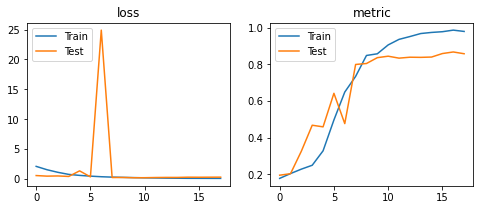

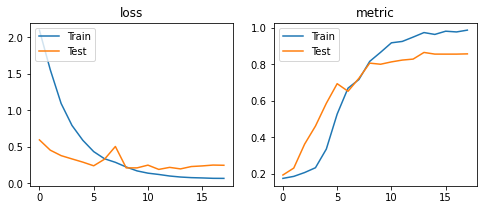

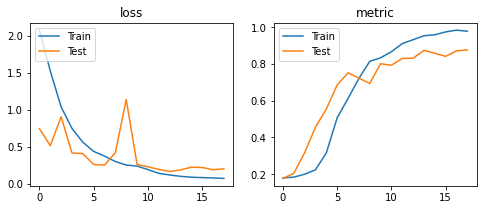

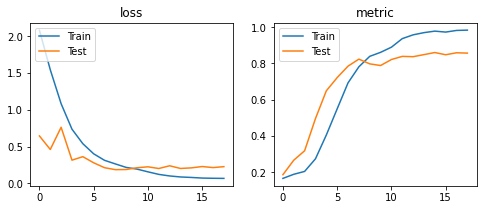

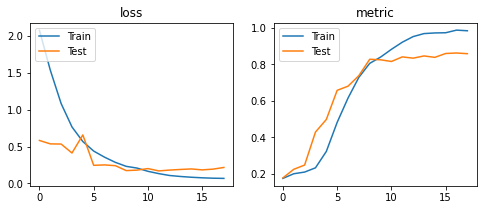

In [50]:
sub = sum(
    map(
        lambda i: train_and_inference(splits, i)[0].set_index('recording_id'),
        range(len(splits))
    )
).reset_index()

In [51]:
sub

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,000316da7,0.525160,0.413148,0.389419,3.052043,0.507734,1.501480,0.437025,0.674895,0.468183,...,0.768396,1.024450,0.509259,0.797945,0.977752,0.544978,0.670131,0.659913,0.454409,0.759431
1,003bc2cb2,0.310937,0.343261,0.293351,1.556455,0.388961,0.308182,0.298190,0.545800,0.319029,...,0.449556,0.390194,4.899994,0.512535,0.528966,0.232597,0.310635,0.295576,0.324867,0.406707
2,0061c037e,0.445024,0.405739,0.382057,1.469275,0.448063,0.928376,0.326075,3.078196,0.484885,...,0.535764,0.526442,0.646145,0.968561,0.460125,0.439032,0.856200,0.696744,0.573634,0.932287
3,010eb14d3,4.630953,0.274430,0.272645,0.254319,0.533650,0.295412,0.259213,0.371994,1.691638,...,0.310149,0.451334,0.353624,0.256604,0.874233,0.347780,0.324119,0.598312,0.345118,0.272876
4,011318064,0.603716,0.355068,0.394844,1.932304,0.552284,0.758393,0.484136,0.696974,0.494875,...,3.680315,2.042281,0.734850,0.641266,2.210652,0.419112,0.610573,0.498328,0.410487,0.569663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,ff68f3ac3,1.107377,0.354059,0.309682,0.805739,0.569601,3.256253,0.353907,0.886557,0.443729,...,0.586857,3.236248,0.481770,0.444902,0.563277,0.572660,1.262590,0.447863,0.340471,4.986193
1988,ff973e852,0.421766,0.456283,0.337811,1.007055,0.413300,0.672086,0.491208,3.652097,0.464407,...,0.601057,1.826587,0.483306,1.015798,0.639086,0.627524,1.095779,0.500860,0.835070,1.130121
1989,ffa5cf6d6,0.451083,0.488925,0.455584,2.236165,0.486659,1.129298,0.424990,1.151612,0.486848,...,0.521751,4.950230,0.615090,1.652909,0.446639,0.459112,0.705243,0.450428,0.429156,0.898461
1990,ffa88cbb8,0.438780,1.546137,0.483774,3.455887,0.417962,0.899100,0.402626,2.586913,0.434360,...,0.413046,0.499788,2.091485,0.441178,0.422319,0.462546,0.566993,0.435386,0.517111,1.124917


In [52]:
sub.describe()

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
count,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,...,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000
mean,0.723111,0.632185,0.519458,1.931536,0.542368,0.862992,0.440423,1.405211,0.564363,0.751235,...,0.806087,1.020839,0.774913,0.605718,0.832604,0.500405,0.613100,0.551506,0.560817,1.026468
std,0.906384,0.550955,0.654038,0.900952,0.388201,0.738781,0.335810,1.065782,0.517197,0.460827,...,0.905489,1.143096,0.864217,0.567219,0.645896,0.259519,0.424547,0.291673,0.475883,0.890460
min,0.198385,0.166724,0.145433,0.168850,0.219781,0.152987,0.154826,0.285947,0.222602,0.209161,...,0.162180,0.180783,0.203296,0.174429,0.237373,0.197949,0.213329,0.211303,0.164238,0.178862
25%,0.376493,0.390070,0.325568,1.226130,0.407799,0.446485,0.322174,0.654742,0.396820,0.515717,...,0.426693,0.471142,0.420952,0.386131,0.471088,0.393695,0.412378,0.436352,0.383848,0.518094
50%,0.441260,0.463589,0.368457,1.815463,0.465260,0.611911,0.400532,0.981993,0.450890,0.665526,...,0.512037,0.567696,0.506933,0.460997,0.574288,0.462480,0.517513,0.496889,0.456812,0.752034
75%,0.564590,0.586969,0.436119,2.555431,0.545779,0.936169,0.472567,1.765965,0.531857,0.839684,...,0.662791,0.764217,0.665828,0.597832,0.896212,0.530350,0.675617,0.573158,0.586257,1.136882
max,4.933527,4.795143,4.884340,4.383065,4.646501,4.706453,4.992667,4.669014,4.945455,4.922486,...,4.921373,4.953791,4.981353,4.987015,4.878748,4.949273,4.998971,3.700564,4.998211,4.993236


In [53]:
sub.to_csv("submission2.csv", index=False)

In [54]:
from IPython.display import FileLink
FileLink(r'submission2.csv')

/kaggle/working/submission2.csv